In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D,Convolution2D,Dropout,Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential, model_from_json
#from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from matplotlib.pyplot import imshow

In [2]:
path = "UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 17335
100_0_0_20170112213500903.jpg.chip.jpg


In [3]:
df = pd.read_csv('age_gender_ethnic_gray.csv')

target = df.iloc[:,1:].to_numpy()
#target = np.array(df['features'].tolist())

## Converting pixels from 1D to 3D
#target = target.reshape(target.shape[0],64,64,3)
#features = df["features"]
#features
#target

In [4]:
images = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(120,120),interpolation=cv2.INTER_AREA)
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    #split_var = file.split('_')
    #ages.append(int(split_var[0]))
    #genders.append(int(split_var[1]) )
    #ethnicity.append(int(split_var[2]) )


In [5]:
features = np.zeros((size,images[0].shape[0],images[0].shape[1],1),dtype = 'float32')
for i in range(size):
    features[i] = images[i]
features = features / 255

target = np.zeros((size,3),dtype='int32')
features = np.zeros((size,images[0].shape[0],images[0].shape[1],3),dtype = 'float32')
for i in range(size):
    target[i,0] = int(ages[i])
    target[i,1] = int(genders[i])
    target[i,2] = int(ethnicity[i])
    features[i] = images[i]
features = features / 255
#display(features[550])

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])
y_train.shape

Samples in Training: 13868
Samples in Testing: 3467


(13868, 3)

In [7]:
inputs = Input(shape=(120,120,1))
conv1 = Conv2D(32, kernel_size=(5, 5),activation='relu')(inputs)
bn1 = BatchNormalization()(conv1)
act1 = Activation(activation='relu')(bn1)
pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(act1)

conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(pool1)
bn2 = BatchNormalization()(conv2)
act2 = Activation(activation='relu')(bn2)
pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(act2)
flat1 = Flatten()(pool2)

conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool2)
bn3 = BatchNormalization()(conv3)
act3 = Activation(activation='relu')(bn3)
pool3 = MaxPooling2D(pool_size=(3, 3))(act3)
flat2 = Flatten()(pool3)

fca = Dense(103, activation='relu')(flat2)
dropa = Dropout(0.7)(fca)

fcg = Dense(80, activation='relu')(flat1)
dropg = Dropout(0.92)(fcg)
#dropg = Dense(20, activation='relu')(dropg)
#dropg = Dropout(0.5)(dropg)

conv4 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool2)
bn4 = BatchNormalization()(conv4)
act4 = Activation(activation='relu')(bn4)
pool4 = MaxPooling2D(pool_size=(3, 3))(act4)
#drope1 = Dropout(0.25)(pool4)
flat3 = Flatten()(pool4)

fce = Dense(200, activation='relu')(flat3)
drope2 = Dropout(0.83)(fce)
"""
drope2 = Dense(100, activation='relu')(drope2)
drope2 = Dropout(0.6)(drope2)"""

age_model = Dense(1, activation='relu', name="Age_Model")(dropa)
gender_model = Dense(1, activation='sigmoid', name="Gender_Model")(dropg)
ethnic_model = Dense(5, activation='softmax',name="Ethnic_Model")(drope2)

In [8]:
early_stopping = EarlyStopping(monitor='val_Ethnic_Model_loss',patience=10, min_delta=0.001,restore_best_weights=True,verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_Ethnic_Model_accuracy', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.000000001)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_Ethnic_Model_accuracy')>0.800) or\
        (logs.get('val_Age_Model_mae')<6.80) or (logs.get('val_Gender_Model_accuracy')>0.900):
            print("\nReached wanted val_accuracy so cancelling training!")
            self.model.stop_training = True
        
callback = [myCallback(),early_stopping,learning_rate_reduction]

In [9]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow_addons as tfa
epoch =  100
init_lr = 0.00002
opt = Adam(learning_rate=init_lr)
#opt = SGD(learning_rate=init_lr, momentum=0.9, nesterov=True, decay=init_lr / epoch)
#opt = RMSprop(learning_rate=init_lr)

losses = {
    "Age_Model": "mean_squared_error",
    "Gender_Model": "binary_crossentropy",
    "Ethnic_Model": "sparse_categorical_crossentropy"
}

metricss ={
    "Age_Model": "mae",
    "Gender_Model": "accuracy",
    "Ethnic_Model": "accuracy"
}

model = Model(inputs=inputs, outputs=[age_model,gender_model,ethnic_model])
model.compile(optimizer = opt, loss =losses,metrics=metricss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 116, 116, 32  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 116, 116, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
g = model.fit(x_train,[y_train[:,0],y_train[:,1],y_train[:,2]],validation_data=(x_test,[y_test[:,0],y_test[:,1],y_test[:,2]]),epochs =epoch, batch_size=16,callbacks=callback, shuffle = True)

Epoch 1/100
867/867 [==============================] - 83s 59ms/step - loss: 456.1854 - Age_Model_loss: 453.5356 - Gender_Model_loss: 0.7191 - Ethnic_Model_loss: 1.9311 - Age_Model_mae: 16.2979 - Gender_Model_accuracy: 0.5818 - Ethnic_Model_accuracy: 0.3080 - val_loss: 281.0396 - val_Age_Model_loss: 279.0309 - val_Gender_Model_loss: 0.5809 - val_Ethnic_Model_loss: 1.4279 - val_Age_Model_mae: 12.4678 - val_Gender_Model_accuracy: 0.7718 - val_Ethnic_Model_accuracy: 0.4641 - lr: 2.0000e-05
Epoch 2/100
867/867 [==============================] - 38s 44ms/step - loss: 272.0616 - Age_Model_loss: 269.9345 - Gender_Model_loss: 0.6150 - Ethnic_Model_loss: 1.5121 - Age_Model_mae: 12.4654 - Gender_Model_accuracy: 0.6219 - Ethnic_Model_accuracy: 0.3761 - val_loss: 231.4959 - val_Age_Model_loss: 229.6878 - val_Gender_Model_loss: 0.5070 - val_Ethnic_Model_loss: 1.3011 - val_Age_Model_mae: 11.3561 - val_Gender_Model_accuracy: 0.8013 - val_Ethnic_Model_accuracy: 0.5195 - lr: 2.0000e-05
Epoch 3/100
867/

Epoch 17/100
867/867 [==============================] - 40s 47ms/step - loss: 159.6624 - Age_Model_loss: 158.2534 - Gender_Model_loss: 0.4429 - Ethnic_Model_loss: 0.9660 - Age_Model_mae: 9.3532 - Gender_Model_accuracy: 0.7572 - Ethnic_Model_accuracy: 0.6382 - val_loss: 103.1121 - val_Age_Model_loss: 102.0538 - val_Gender_Model_loss: 0.2987 - val_Ethnic_Model_loss: 0.7596 - val_Age_Model_mae: 7.4579 - val_Gender_Model_accuracy: 0.8641 - val_Ethnic_Model_accuracy: 0.7289 - lr: 2.0000e-05
Epoch 18/100
867/867 [==============================] - 40s 46ms/step - loss: 157.8739 - Age_Model_loss: 156.4879 - Gender_Model_loss: 0.4409 - Ethnic_Model_loss: 0.9451 - Age_Model_mae: 9.2780 - Gender_Model_accuracy: 0.7589 - Ethnic_Model_accuracy: 0.6365 - val_loss: 102.8515 - val_Age_Model_loss: 101.7904 - val_Gender_Model_loss: 0.3007 - val_Ethnic_Model_loss: 0.7605 - val_Age_Model_mae: 7.4483 - val_Gender_Model_accuracy: 0.8627 - val_Ethnic_Model_accuracy: 0.7329 - lr: 2.0000e-05
Epoch 19/100
867/8

Epoch 48/100
867/867 [==============================] - 39s 45ms/step - loss: 126.1943 - Age_Model_loss: 125.2041 - Gender_Model_loss: 0.3282 - Ethnic_Model_loss: 0.6619 - Age_Model_mae: 8.2904 - Gender_Model_accuracy: 0.8205 - Ethnic_Model_accuracy: 0.7399 - val_loss: 92.0427 - val_Age_Model_loss: 91.0805 - val_Gender_Model_loss: 0.2862 - val_Ethnic_Model_loss: 0.6760 - val_Age_Model_mae: 7.0657 - val_Gender_Model_accuracy: 0.8740 - val_Ethnic_Model_accuracy: 0.7638 - lr: 1.2500e-06
Epoch 49/100
867/867 [==============================] - 40s 46ms/step - loss: 129.5533 - Age_Model_loss: 128.5497 - Gender_Model_loss: 0.3361 - Ethnic_Model_loss: 0.6675 - Age_Model_mae: 8.3220 - Gender_Model_accuracy: 0.8223 - Ethnic_Model_accuracy: 0.7423 - val_loss: 96.4786 - val_Age_Model_loss: 95.5169 - val_Gender_Model_loss: 0.2859 - val_Ethnic_Model_loss: 0.6757 - val_Age_Model_mae: 7.2420 - val_Gender_Model_accuracy: 0.8728 - val_Ethnic_Model_accuracy: 0.7618 - lr: 1.2500e-06
Epoch 50/100
867/867 [

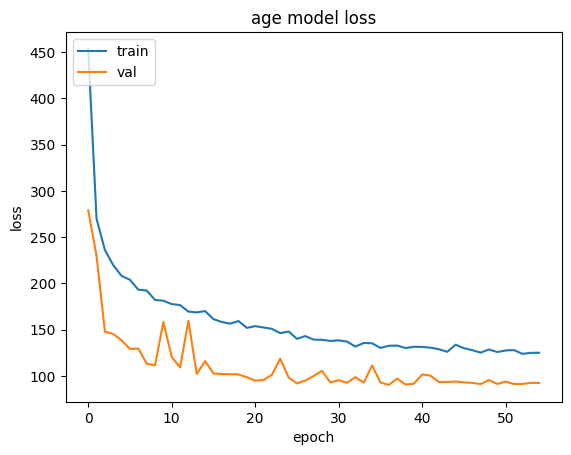

In [31]:
history = g
plt.plot(history.history['Age_Model_loss'])
plt.plot(history.history['val_Age_Model_loss'])
plt.title('age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

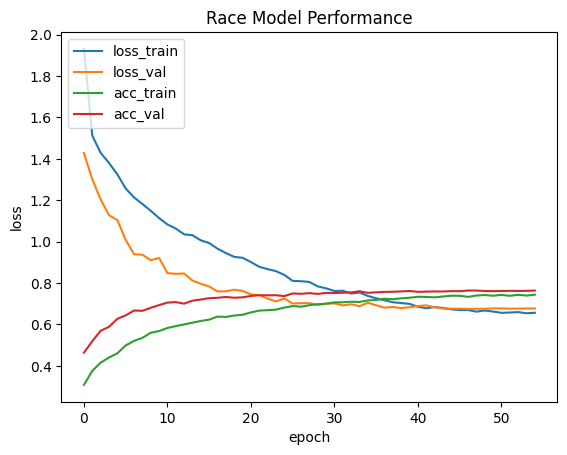

In [42]:
history = g
plt.plot(history.history['Ethnic_Model_loss'])
plt.plot(history.history['val_Ethnic_Model_loss'])
plt.plot(history.history['Ethnic_Model_accuracy'])
plt.plot(history.history['val_Ethnic_Model_accuracy'])
plt.title('Race Model Performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_train', 'loss_val', 'acc_train', 'acc_val'], loc='upper left')
plt.show()

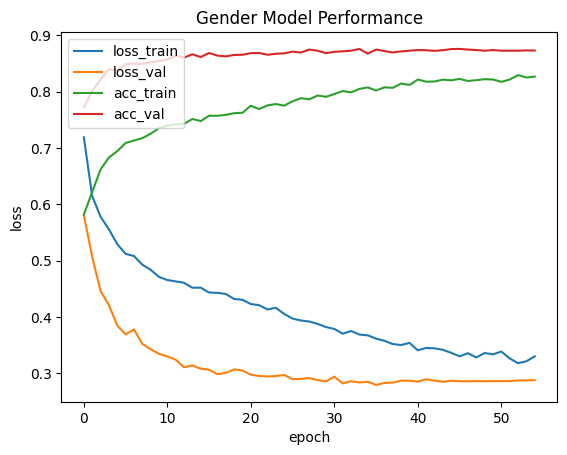

In [43]:
history = g
plt.plot(history.history['Gender_Model_loss'])
plt.plot(history.history['val_Gender_Model_loss'])
plt.plot(history.history['Gender_Model_accuracy'])
plt.plot(history.history['val_Gender_Model_accuracy'])
plt.title('Gender Model Performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_train', 'loss_val', 'acc_train', 'acc_val'], loc='upper left')
plt.show()

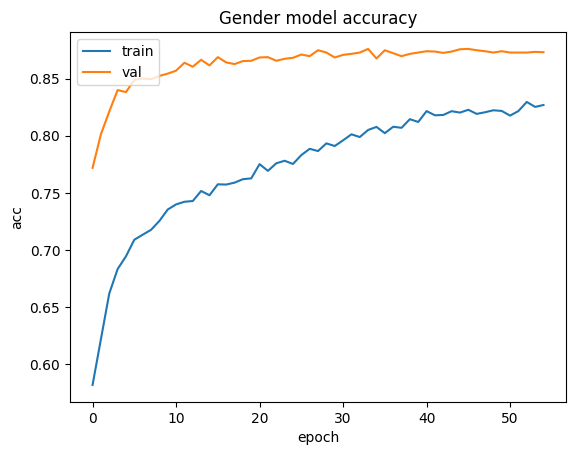

In [45]:
history = g
plt.plot(history.history['Gender_Model_accuracy'])
plt.plot(history.history['val_Gender_Model_accuracy'])
plt.title('Gender model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

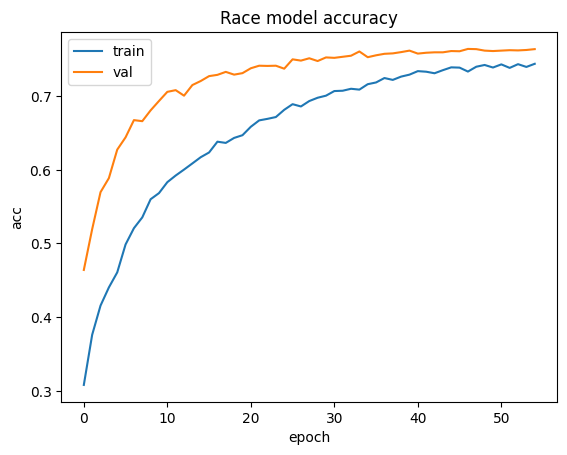

In [44]:
history = g
plt.plot(history.history['Ethnic_Model_accuracy'])
plt.plot(history.history['val_Ethnic_Model_accuracy'])
plt.title('Race model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

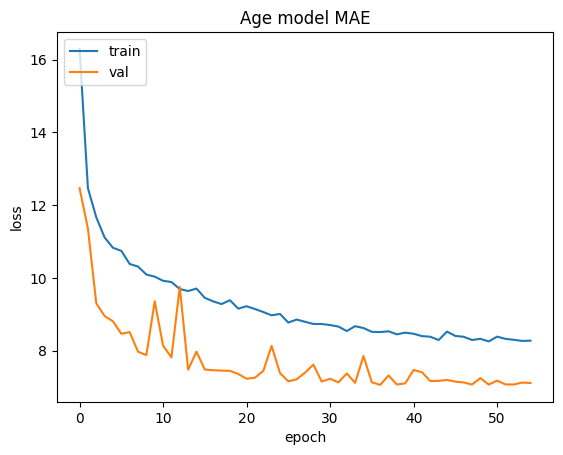

In [46]:
history = g
plt.plot(history.history['Age_Model_mae'])
plt.plot(history.history['val_Age_Model_mae'])
plt.title('Age model MAE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# serialize model to JSON
model_json = model.to_json()
with open("weights/model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weights/model2_weights.h5")
print("Saved model to disk")

saved_model_path = "./my_model.h5"

# YOUR CODE HERE
model.save(saved_model_path)

!tensorflowjs_converter --input_format=keras {saved_model_path} ./

In [6]:
json_file = open('weights/model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights/model2_weights.h5")
print("Loaded model from disk")



Loaded model from disk


loaded_model=tf.keras.models.load_model("model")
print("Loaded model from disk")

In [38]:
test = np.array(images[11500:11509])/255
#prediction = loaded_model.predict(test)
prediction = model.predict(test)
print(test.shape)
#prediction

1/1 [==============================] - 0s 27ms/step
(9, 120, 120, 1)


In [10]:
loaded_model.evaluate(x_test,[y_test[:,0],y_test[:,1],y_test[:,2]], verbose=0, return_dict=True)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [40]:
label_a = [int(i) for i in prediction[0].round().astype(int)]
label_g = [int(i) for i in prediction[1].round().astype(int)]
label_e = [np.argmax(i) for i in prediction[2]]
#label_e = np.argsort(np.max(prediction[2], axis=1))[-2]
#label_e = np.delete(prediction[2], np.argmax(prediction[2]))#.argsort()[:,-2]#np.argmax(prediction[2])
#label_e = np.argmax(prediction[2])
#prediction[2][0,np.argmax(prediction[2])] = 0

In [26]:
print(label_a,label_g,label_e)

[54, 40, 42, 35, 31, 45, 42, 41, 39] [0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 2, 0]


In [27]:
data = {'predicted_age': label_a,
        'predicted_gender': label_g,
       'predicted_ethnicity': label_e}
prediction_df = pd.DataFrame(data)
prediction_df
prediction_df.to_csv('prediction_data.csv', index=False)

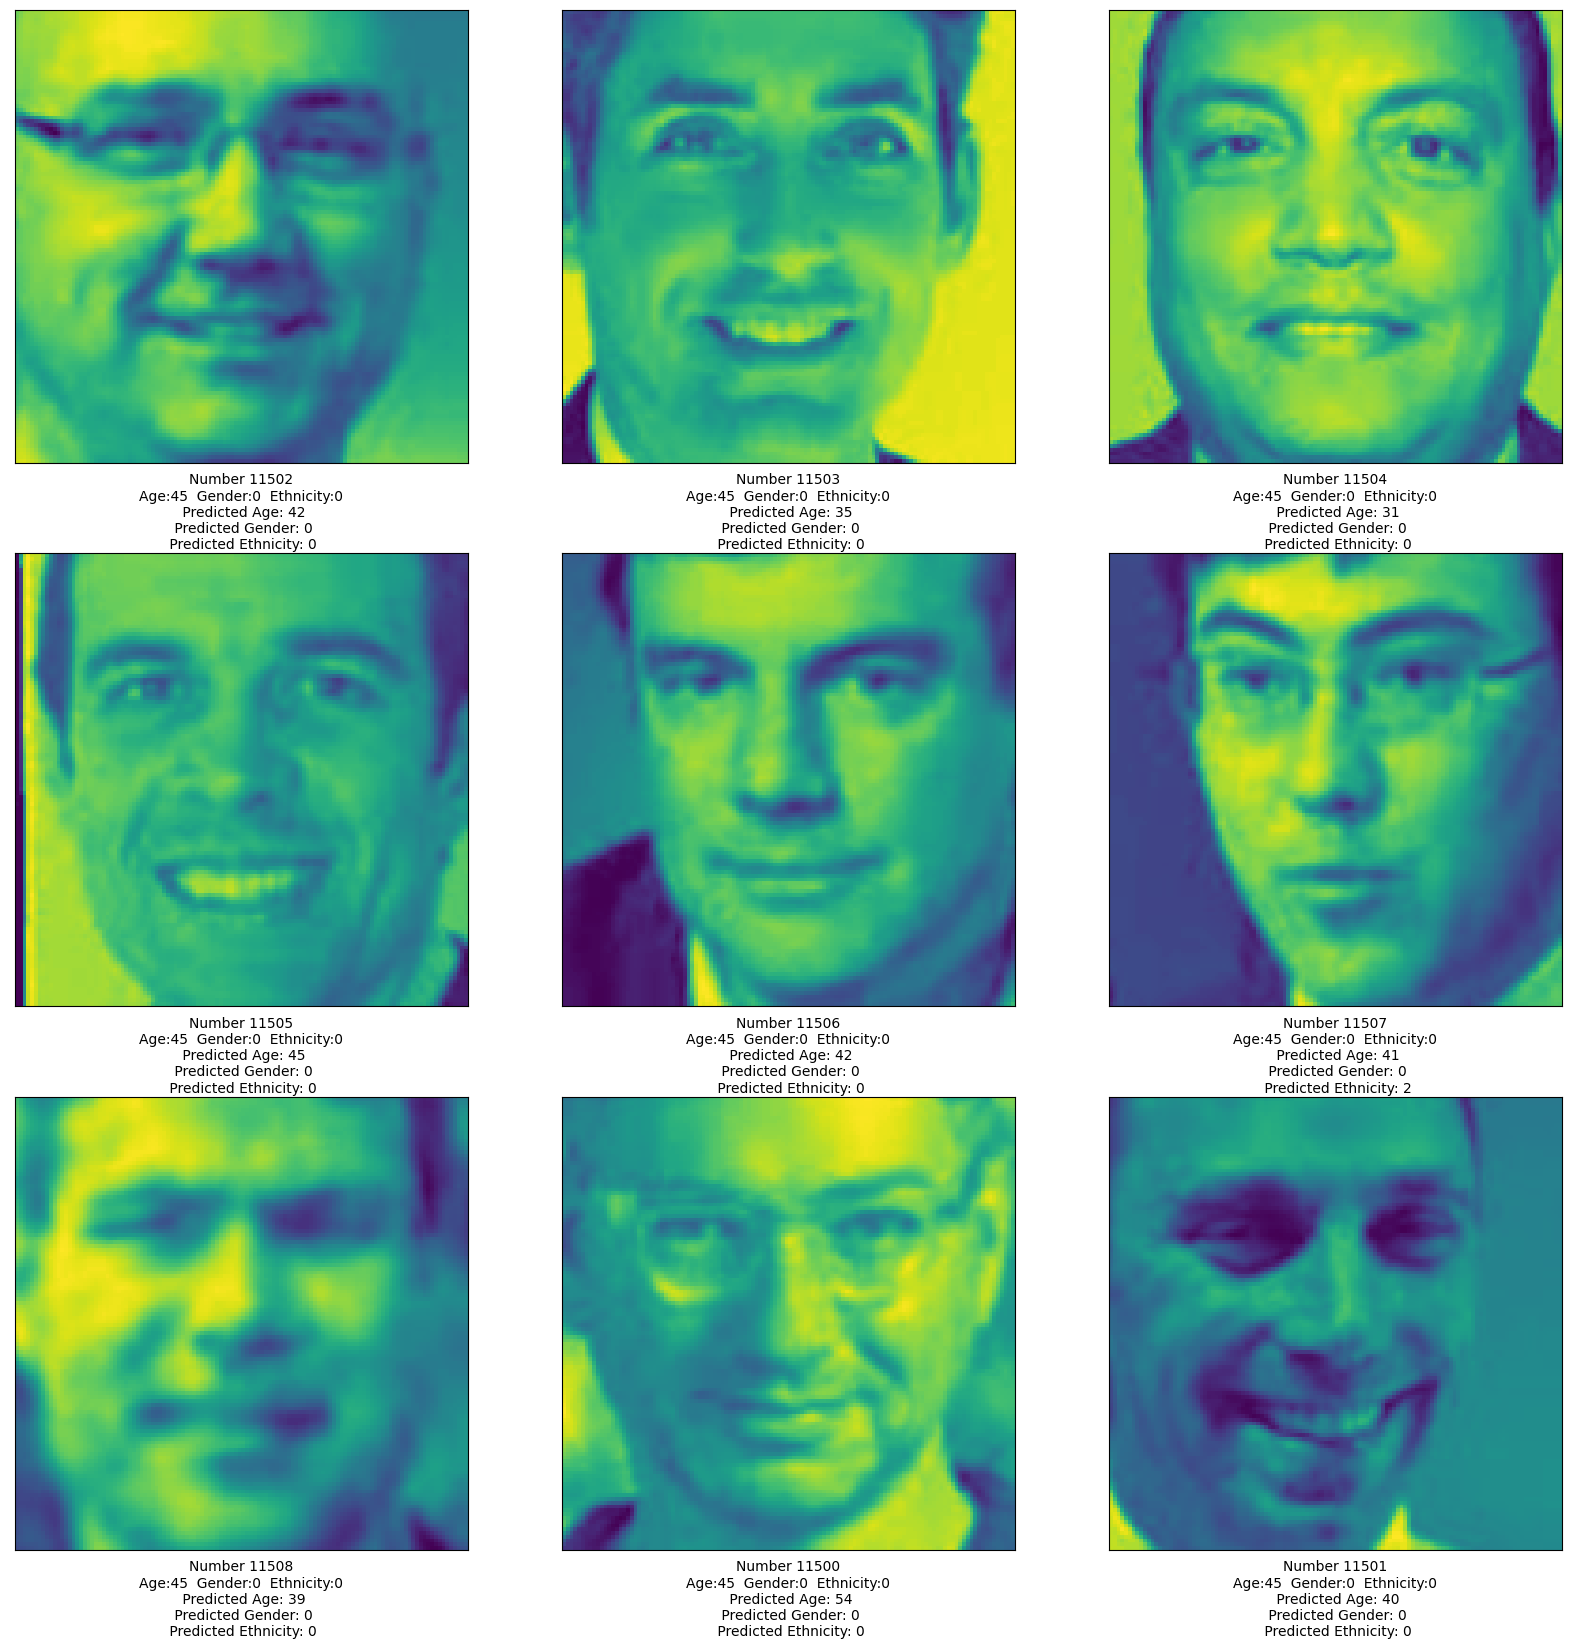

In [28]:
plt.figure(figsize=(20,20))
for j,i in enumerate(range(11500,11509)):
    plt.subplot(3,3,(i%9)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(
        "Number " + str(i) +
        "\nAge:"+str(target[i,0])+
        "  Gender:"+ str(target[i,1])+
        "  Ethnicity:"+str(target[i,2])+
        "\n Predicted Age: "+str(label_a[j])+
        "\n Predicted Gender: "+str(label_g[j])+
        "\n Predicted Ethnicity: "+str(label_e[j])
    )
plt.show()

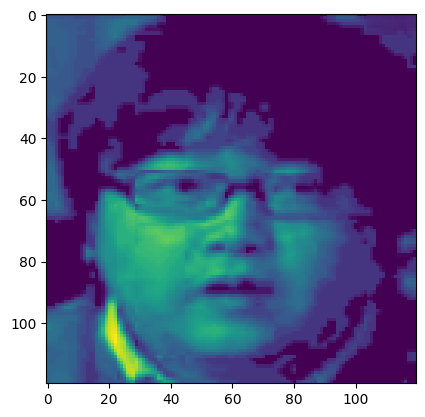

(120, 120, 1)
(1, 120, 120, 1)


In [29]:
from tensorflow.keras.utils import load_img, img_to_array
import imutils

"""image = cv2.imread("test2.jpg")
image = cv2.resize(image,dsize=(64,64))
image = img_to_array(image)
img = np.expand_dims(image, axis = 0)
img /= 255"""
path="test12.png"
test_img = cv2.imread(path,0)
test_img = cv2.resize(test_img,dsize=(120,120), interpolation=cv2.INTER_AREA)
#test_img = imutils.resize(test_img, height=64)#, height=64)
test_img = test_img.reshape((test_img.shape[0],test_img.shape[1],1))


plt.imshow(test_img)
plt.show()
print(test_img.shape)
test_img = np.expand_dims(test_img, axis=0)/255
print(test_img.shape)

In [30]:
#prediction = loaded_model.predict(test_img)
prediction = model.predict(test_img)
print(prediction)
label_a = [int(i) for i in prediction[0].round().astype(int)]
label_g = [int(i) for i in prediction[1].round().astype(int)]
label_e = [np.argmax(i) for i in prediction[2]]
print(label_a,label_g,label_e)

1/1 [==============================] - 0s 95ms/step
[array([[37.393917]], dtype=float32), array([[0.00102378]], dtype=float32), array([[0.0042362 , 0.72587395, 0.16898967, 0.02682066, 0.07407959]],
      dtype=float32)]
[37] [0] [1]


loaded_model.save('my_model.h5')